# Preserving Privacy in a Social Distancing Detector

We are currently living through  COVID-19, a global pandemic which has fundamentally altered how we live and how we interact with other people. 

As you all know, one of the best ways to reduce the spread of the pandemic is to practice **social distancing**. This means staying at least six feet away from people who we don't live with. 

Some workplaces have implemented social distancing *detectors*, which use computer vision technology to determine if people are staying six feet away from each other. However, many people have argued that this detection technology is a huge violation of **privacy**! **What risks could this technology cause?**


In this notebook, we will implement a social distancing detector and explore one technique for preserving privacy in our detector.

Here's the plan:
*   Use a YOLO model to find people in an image
*   Calculate the distance between people to check whether people are socially distanced
*   Blur out people's faces to preserve privacy!



<img src="https://stjude.scene7.com/is/image/stjude/social-distancing-together-6-feet?fit=crop,1&fmt=png-alpha&wid=1200" width="800"/>

## Important: Go to Runtime > Check runtime type is GPU as the hardware acceleration. 

In [ ]:
#@title Run this to cell to get started! This'll load some packages and set up some dependencies for us
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from PIL import ImageFilter
import gdown
from IPython.display import HTML

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2
from copy import deepcopy
import pandas as pd

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Prepare data
DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)

image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
image_path = os.path.join(DATA_ROOT, 'image.jpg')
gdown.download(image_url, image_path, True)

# image_url = 'https://drive.google.com/uc?id=1SZOfMIhOZ71phdxoRneIm6aFUK_SnyQE'
# img_sd1_path = os.path.join(DATA_ROOT, 'social_distance1.jpg')
# gdown.download(image_url, img_sd1_path, True)

# image_url = 'https://drive.google.com/uc?id=1cQcapqyjaPFc5gkAVqZ2xDWFY_q2A6IM'
# img_sd2_path = os.path.join(DATA_ROOT, 'social_distance3.jpg')
# gdown.download(image_url, img_sd2_path, True)

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%207_%20Healthcare%20Privacy/yolo.h5"
model_path = os.path.join(DATA_ROOT, 'yolo.h5')

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]  

sim_thresh = 0.45

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w
          
          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]
              
              if((classes <= obj_thresh).all()): continue
              
              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height  
            
              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)
    
    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes
        
def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1
        
        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)    

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes_and_get_coordinates(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    co_ordinates_with_labels = []
    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        #print(label, (left, top), (right, bottom))
        co_ordinates_with_labels.append([predicted_class, score, [(left, top), (right, bottom)]])
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image,  co_ordinates_with_labels

net_h, net_w = 416, 416
#Load and preprocess the image
image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
new_image = preprocess_input(image_pil, net_h, net_w)

Found GPU at: /device:GPU:0
--2022-03-05 03:35:06--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%207_%20Healthcare%20Privacy/yolo.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248686624 (237M) [application/octet-stream]
Saving to: ‘yolo.h5’

yolo.h5             100%[===================>] 237.17M   132MB/s    in 1.8s    

2022-03-05 03:35:08 (132 MB/s) - ‘yolo.h5’ saved [248686624/248686624]



## Detecting people

### Object detection

The first step in implementing a social distancing detector is to find out where the people are in an image! We need to use an algorithm for **object detection**.

**Question**: What algorithms have you seen before that we could use for object detection?

<img src="https://upload.wikimedia.org/wikipedia/commons/3/38/Detected-with-YOLO--Schreibtisch-mit-Objekten.jpg" width="600"/>

### YOLO: You Only Look Once

A true social distancing detector will analyze *real-time videos* for social distancing violations. In this notebook, we'll start by performing detection on *images* - in the future, we could extend to video!

**Question**: What difficulties might arise in performing detection on real-time videos?

In [ ]:
#@title Run to see an example of a real-time social distancing detector!
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/15iIV1Lff-M" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

As you might have discussed, one of the key difficulties with performing detection on real-time videos is performing detection *fast*. So far, in this course, we have only performed detection on images. However, as you have likely noticed, running a traditional **convolutional neural network** (CNN) on our data *takes some time*. We want to cut down this time as much as possible, to the point where we can perform detection *in real-time*.

This is where the **YOLO** (You Only Look Once) detection algorithm comes in. Invented in 2015 by Redmond et al., the YOLO algorithm is known for its extremely fast speed without significant loss in accuracy. We won't go into too much detail about the inner workings of the algorithm here, but essentially YOLO performs just a single forward pass over images at testing time and predicts all bounding boxes and class labels for objects in the image at the same time.

**Optional**: To learn more about the YOLO algorithm, you can [read the original paper here](https://arxiv.org/abs/1506.02640).

**Optional**: You can also [watch this TED talk](https://www.youtube.com/watch?v=Cgxsv1riJhI&feature=youtu.be) Joseph Redmond gave about YOLO.

In this notebook, we will use the YOLO algorithm. We have prepared a trained YOLO model for you to use!

**Exercise**: Load in the YOLO model. The model weights are stored in the variable `model_path`.

**Hint**: Check out the `load_model` function in Keras. You can [find the documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model).

In [ ]:
yolo = tf.keras.models.load_model(model_path) ## YOUR CODE HERE

### Using YOLO: Generating bounding boxes
In this notebook, we will test our social distancing detector with the following image (some of you might recognize it from the television show *The Big Bang Theory*). Run the following cell to display the initial image.

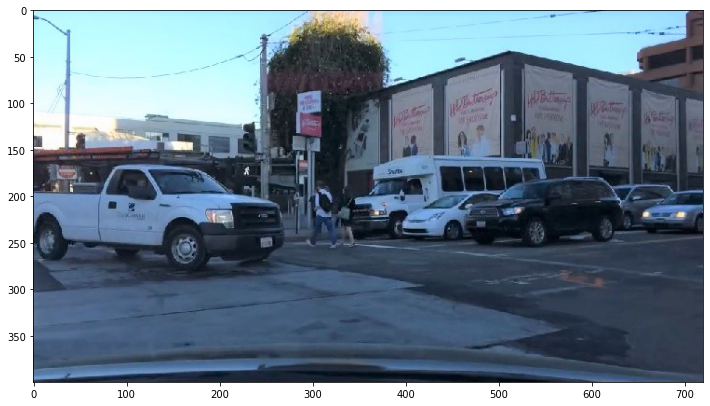

In [ ]:
#@title Run this cell to display the initial image
plt.figure(figsize=(12,12))
plt.imshow(image_pil)
plt.show()

We want to use YOLO to generate **bounding boxes** around the people in this image. Our YOLO model is already trained -- all we need to do is predict the bounding boxes!

**Exercise**: Use YOLO to predict bounding boxes for the image. The numpy array containing the image data is named `new_image`.

In [ ]:
yolo_pred = yolo.predict(new_image) ## YOUR CODE HERE

Now let's see what bounding boxes YOLO predicted!

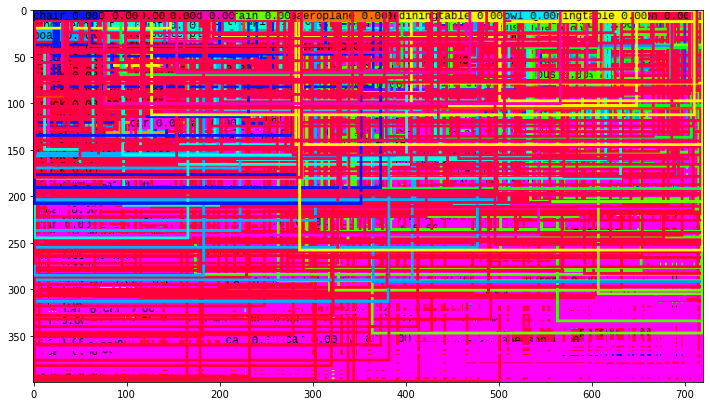

In [ ]:
#@title Run this cell to plot the predicted bounding boxes

anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]

boxes = decode_netout(yolo_pred, 0, anchors, image_h, image_w, net_h, net_w)

# Draw bounding boxes on the image using labels and get the co-ordinates
image_detect,coordinates_with_labels = draw_boxes_and_get_coordinates(image_pil, boxes, labels) 

plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()

Huh? Why are there so many boxes?

As it turns out, YOLO generates a *ton* of bounding boxes and calculates the **likelihood** (the probability) of each bounding box. However, it *does not* choose which bounding boxes to return to the user. Instead, it merely assigns each bounding box a likelihood and returns all the bounding boxes along with their associated likelihoods. It's up to you as the user to decide how flexible you want to be in deciding what counts as an instance of the object you're looking for! 

You can choose the **threshold** likelihood. Any bounding boxes which have likelihoods that are above this threshold will be kept, and the rest will be discarded.

**Question**: If your YOLO model returns too many bounding boxes, should you increase or decrease your threshold? Why?

**Exercise**: Try changing the below threshold value to see how it affects your bounding boxes! See if you can find a good threshold value!

In [ ]:
obj_thresh = .4 ## TODO: Replace with your threshold value!

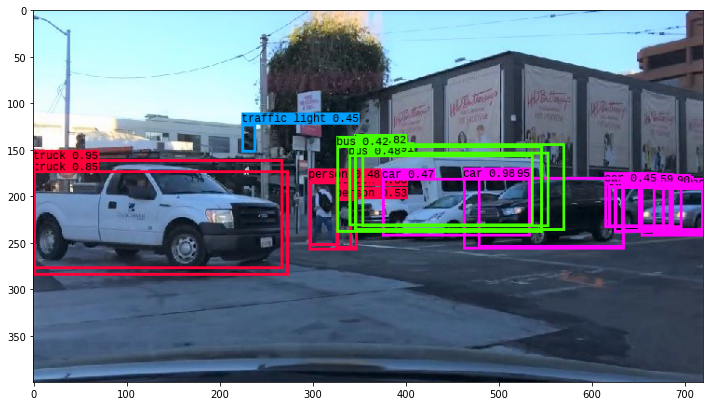

In [ ]:
#@title Run this cell to plot just the bounding boxes which pass your threshold

# Decode the output of the network
boxes = decode_netout(yolo_pred, obj_thresh, anchors, image_h, image_w, net_h, net_w)

# Draw bounding boxes on the image using labels and get the co-ordinates
image_detect,coordinates_with_labels = draw_boxes_and_get_coordinates(image_pil, boxes, labels) 

plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()

### Optional: Non-maximal suppression

As you have likely noticed, many objects have multiple bounding boxes drawn around them.

**Question**: Why might objects have multiple bounding boxes drawn around them?

We only want an object to have one bounding box around it. To achieve this, we will use a technique called **non-maximal suppression**. Essentially, we will compare all our bounding boxes against each other and if two bounding boxes are similar enough, then we will keep the bounding box with the higher likelihood and discard the other. We define similarity of bounding boxes using a metric known as **intersection over union** (IoU).

![link](https://miro.medium.com/max/846/1*2w493Z_V6-sE_3aYa48a9w.png)

**Question**: Why is intersection over union a good metric for calculating similarity of bounding boxes?

We will calculate the intersection over union for all pairs of bounding boxes in our image. If the intersection over union for a pair of bounding boxes is greater than a similarity threshold, then we will discard the bounding box with the smaller likelihood.

**Question**: If your YOLO model contains objects with multiple bounding boxes, should you increase or decrease your similarity threshold? Why?

**Exercise**: Try changing the below threshold value to see how it affects your bounding boxes! See if you can find a good threshold value!

In [ ]:
sim_thresh = .5 ## TODO: Replace with your similarity threshold value!

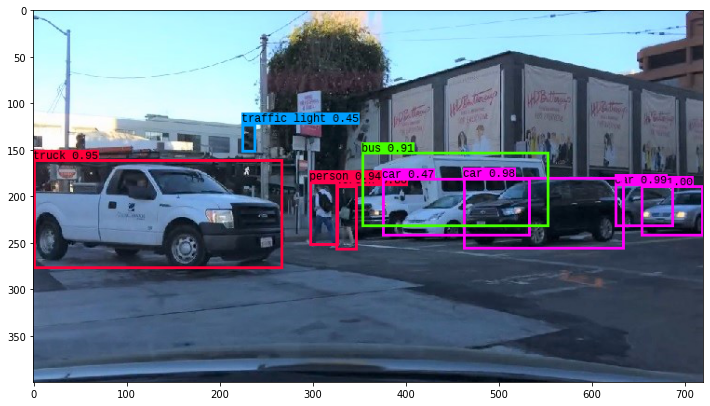

In [ ]:
#@title Run this cell to plot just the bounding boxes which pass your similarity threshold

# Decode the output of the network
boxes = decode_netout(yolo_pred, obj_thresh, anchors, image_h, image_w, net_h, net_w)

# Suppress non-maximal boxes
boxes = do_nms(boxes, sim_thresh, obj_thresh)

# Draw bounding boxes on the image using labels and get the co-ordinates
image_detect,coordinates_with_labels = draw_boxes_and_get_coordinates(image_pil, boxes, labels) 

plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()

### Filtering out non-people

Since we are only interested in detecting social distancing between *people*, we will only consider bounding boxes which have the label `person`.



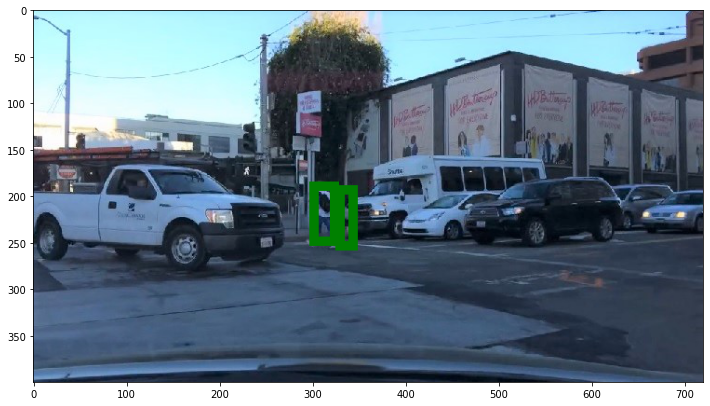

In [ ]:
#@title Run this cell to plot just the bounding boxes with `person` labels

def filter_person_category(image_pil,coordinates_with_labels):
  image = image_pil.copy()
  person_coordinates = []
  
  img_draw = ImageDraw.Draw(image)
  
  for i in coordinates_with_labels:
    label = i[0]
    confidence = i[1]
    coordinates= i[2]
    top_left_coordinates= i[2][0]
    bottom_right_coordinates = i[2][1]
    if label =="person":
      person_coordinates.append(coordinates)
      
      img_draw.rectangle([top_left_coordinates[0], top_left_coordinates[1], 
                          bottom_right_coordinates[0], bottom_right_coordinates[1]],
                         outline='green',width=10)

  del img_draw
  return image, person_coordinates

image_person, person_coordinates = filter_person_category(image_pil,coordinates_with_labels)

plt.figure(figsize=(12,12))
plt.imshow(image_person)
plt.show()

## Privacy concern: Let's anonymize the people

### Blurring

There have been growing concerns that using computer vision in surveillance and public safety systems is a huge privacy violation. In order to, at least partially, address this issue, we will blur all the people in our social distancing detector. That way, while we will be able to detect if there is or is not socially distancing, we will not be able to detect who is or is not violating social distancing procedures.

**Question**: Do you think this blur method is sufficient for satisfying privacy concerns? Why or why not?

Below is the function used to blur the image. We will blur parts of the image specific to person pixels. **Can you explain on a high level** what each part of this code is doing?

We will use a `BLUR` filter to blur the people in our image. Using this filter, we can blur a few times to get the effect we are seeking.

**Exercise**: Try changing the below number of blurs to see how it affects your anonymization! See if you can find a good number of blurs!

In [ ]:
num_blurs = 3 ## TODO: Replace with your number of blurs!

In [ ]:
def anonymize_person_pixelate(image, person_coordinates):
  image_copy = image.copy()
  for c in person_coordinates:
    startX = c[0][0]
    startY = c[0][1]
    endX = c[1][0]
    endY = c[1][1]
    
    # Get the bounding box co-ordinates for every person in the image
    box = (startX, startY, endX, endY)
    
    # Crop that particular person's bbox co-ordinates
    ic = image_copy.crop(box)

    # Blur the person's image
    for i in range(num_blurs):  # with the BLUR filter, you can blur a few times to get the effect you're seeking
      ic = ic.filter(ImageFilter.BLUR)
    
    # Paste the blurred image back to the original image
    image_copy.paste(ic, box)

  return image_copy

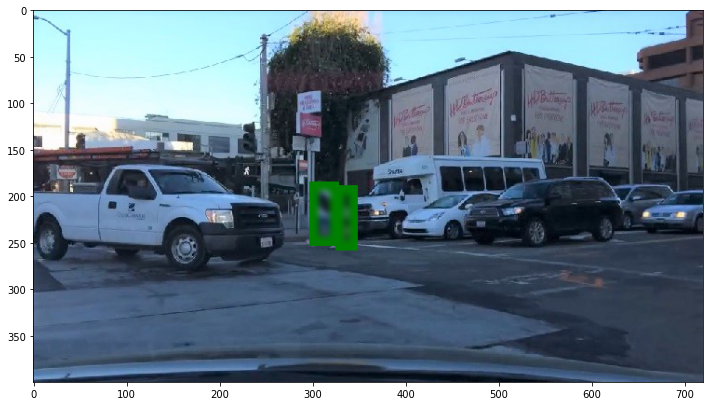

In [ ]:
#@title Run this cell to use our blur function to anonymize our image

image = anonymize_person_pixelate(image_person, person_coordinates)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

### Ethics Discussion

As we begin implementing our social distancing detector, we want you to think about the ethical consequences of actually implementing such a detector.

**Question**: What are the risks and benefits of using AI to detect social distancing violations? What are the situations (if any) where it would be a good idea to use this sort of computer vision AI?

**Question**: One application of computer vision is in surveillance against crime. Given what you know about bias in AI and criminal justice, what groups of people might face [particularly serious privacy risks](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)? 

**Question**: What technical designs should you implement in computer vision and other AI systems to prevent your technology from causing harm (e.g. privacy and safety violations)?

**Question**: What laws and policies should we pass in order to prevent computer vision technology from causing harm?

## Advanced: Detecting (the lack of) social distancing

### Computing midpoints

Now that we have detected the people in our image, drawn bounding boxes around them, and blurred them, we next need to determine if they are social distancing or not. We will make this determination by computing the distances between the bottom center midpoints of our bounding boxes.

**Exercise**: Fill in the function below to compute the *bottom center* midpoint of each bounding box. Add all the midpoints to the `midpoints` list and return it.

**Note**: `person_coordinates` is a list of doubly-nested tuples. For example, the data in `person_coordinates` is structured like:
```
person_coordinates = [
  ((x1, y1), (x2, y2)), #Person 1 
  ((x1, y1), (x2, y2)), #Person 2
  ((x1, y1), (x2, y2)), #Person 3
  ...
]
```
Each entry of the list `person_coordinates` is a pair of tuples, which represent the bounding box around one person. The first tuple in the pair refers to the x,y coordinates of the top left corner of the bounding box. The second tuple in the pair refers to the x,y coordinates of the bottom right corner of the bounding box.

In [ ]:
def get_midpoints(image, person_coordinates):
  midpoints = []

  ## BEGIN YOUR CODE HERE
  pass
  ## END YOUR CODE HERE

  return midpoints

midpoints = get_midpoints(image_pil,person_coordinates)

### Computing distances between midpoints

Now that we have found all the bottom center midpoints of the person bounding boxes, we will compute the distances between each possible pair of midpoints. Gotta make sure everybody is keeping socially distant!

**Exercise**: Fill in the function below to compute the distance between *each possible pair* of midpoints. Store all the distances in the `dist` matrix. For example, the distance between person 0 and person 3 should be stored in `dist[0][3]`, and the distance between person 5 and person 2 should be stored in `dist[5][2]`.

**Note**: You should use the function `distance.euclidean` to compute the distance between a pair of midpoints. To learn how to use this function, you should [check the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html).

In [ ]:
from scipy.spatial import distance

def compute_distances(midpoints):
  num_people = len(midpoints)
  dists = np.zeros((num_people, num_people))
  
  ## BEGIN YOUR CODE HERE
  pass
  ## END YOUR CODE HERE

  return dists

dists = compute_distances(midpoints)

### Finding people who aren't socially distancing 😮

We have detected the people in our image and calculated the distances between all of them. All that's left to do now is check who is sufficiently apart from who!

Technically, as we can see, nobody in this image is socially distanced according to WHO guidelines (six feet!). For this notebook, we will use a smaller social distance threshold, which we have set to `250` pixels.

**Exercise**: Fill in the function below to find all people who are not socially distancing (having a distance between them of less than 250). Store the *indices* of the people who are not socially distancing in `people_found`. For example, if for person i and person j, `dists[i][j]` is less than `threshold`, you should store both i and j in `people_found` (provided they are not already in `people_found` of course).

**Note**: Make sure you *don't* check the distance between a person and themselves! That distance will, by definition, always be 0.



In [ ]:
SOCIAL_DISTANCE_THRESHOLD = 250

def find_people_not_distancing(dists, threshold):
  people_found = []

  ## BEGIN YOUR CODE HERE
  pass
  ## END YOUR CODE HERE

  return people_found

people_found = find_people_not_distancing(dists, SOCIAL_DISTANCE_THRESHOLD)

In [ ]:
#@title Run this cell to display who is socially distancing and who is not

if len(people_found) == 0:
  print("Everybody in the image is socially distant.\n")
else:
  print("People with a red bounding box are not socially distancing.\n")

def plot_red_bbox(img, co_ordinates, people):
  img_draw = ImageDraw.Draw(img)
  
  for i in people:
    (x1,y1) = co_ordinates[i][0]
    (x2,y2) = co_ordinates[i][1]
    img_draw.rectangle([x1,y1,x2,y2],outline='red',width=10)
  del img_draw
  return img

img = plot_red_bbox(image_person, person_coordinates, people_found)

plt.figure(figsize=(20,10))
plt.imshow(img)